# Disentanglement analysis of colored-bar-MNIST

Here, we will load the embedded colored-bar-MNIST dataset, which when fed through the VAE produces a 32-dimensional embedding.

In [2]:
%load_ext autoreload
%autoreload 2

In [374]:
import math
import os
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import normflows as nf
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets.utils as dataset_utils
from PIL import Image
from pl_bolts.models.autoencoders.components import resnet18_decoder, resnet18_encoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import save_image

from gendis.causal.modelv3 import CausalFlowModel, CausalNormalizingFlow
from gendis.datasets import MultiDistrDataModule

In [357]:
def show_imgs(imgs, title=None, row_size=4, figsize_scale=1.0, ytick_labels=None):
    # Form a grid of pictures (we use max. 8 columns)
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    is_int = (
        imgs.dtype == torch.int32
        if isinstance(imgs, torch.Tensor)
        else imgs[0].dtype == torch.int32
    )
    ncol = min(num_imgs, row_size)
    nrow = int(math.ceil(num_imgs / ncol))
    imgs = torchvision.utils.make_grid(
        imgs, nrow=row_size, pad_value=128 if is_int else 0.5
    )
    np_imgs = imgs.cpu().numpy()
    # Plot the grid
    fig, ax = plt.subplots(
        figsize=(figsize_scale * 1.5 * nrow * 2, figsize_scale * 1.5 * ncol)
    )
    plt.imshow(np.transpose(np_imgs, (1, 2, 0)), interpolation="nearest")
    if title is not None:
        plt.title(title)
    # plt.axis("off")
    plt.axis("on")
    ax.set_xticks([])

    # if ytick_labels is not None:
    #     # Number of images per row
    #     img_per_row = num_imgs // nrow + (num_imgs % nrow > 0)
    #     # Set yticks at the center of each row of images
    #     yticks = [i * np_imgs.shape[1] / img_per_row + np_imgs.shape[1] / (2 * img_per_row) for i in range(img_per_row)]
    #     ax.set_yticks(yticks)
    #     ax.set_yticklabels(ytick_labels[:img_per_row])
    if ytick_labels is not None:
        # print(nrow)
        ax.set_yticks([(i + 0.5) * imgs.shape[1] / nrow for i in range(nrow)])
        ax.set_yticklabels(ytick_labels[:nrow])
    # ax.set_yticks([(i + 0.5) * images.shape[1] / nrow for i in range(nrow)])
    # plt.close()
    return fig, ax

In [388]:
root = "/Users/adam2392/pytorch_data/full-causal-mnistv1/"
root = Path(root)
new_root = root / "causaldigibar_reduction_datv1/"

# root = "/Users/adam2392/pytorch_data/full-causal-mnistv2/"
# root = Path(root)
# new_root = root / "causaldigibar_reduction_datv2/"

batch_size = 40 * 4
num_workers = 1

data_module = MultiDistrDataModule(
    root=new_root,
    graph_type="chain",
    batch_size=batch_size,
    stratify_distrs=True,
    transform=None,
    num_workers=num_workers,
    dataset_name="digitcolorbar",
)
data_module.setup()

In [389]:
# randomly sample
batch = next(train_iter)
sample_imgs, sample_labels, sample_target = batch

print(sample_imgs.shape, sample_labels.shape, sample_target.shape)

torch.Size([40, 32]) torch.Size([40, 4]) torch.Size([40, 3])


In [346]:
print(sample_target)

tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 1]], dtype=torch.int32)


In [347]:
print(sample_labels[:, -1])

tensor([1., 2., 0., 0., 2., 3., 2., 1., 3., 0., 3., 2., 0., 3., 1., 1.])


In [410]:
root = Path("/Users/adam2392/pytorch_data/data/causal/")
graph_type = "chain"

# No independent noise factor
seed = 3
epoch = 248
step = 209907

seed = 2
epoch = 243
step = 205692
results_dir = (
    root
    / f"64hidden-mlp-nf-onvae-reductionv1-cosinelr-batch256-{graph_type}-seed={seed}"
)

checkpoint_fname = results_dir / f"v1-epoch={epoch}-step={step}.ckpt"
model = CausalFlowModel.load_from_checkpoint(checkpoint_fname)

/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [411]:
imgs = []
labels = []
targets = []

for idx in data_module.train_dataset.indices:
    img, label, target = data_module.dataset[idx]
    imgs.append(img)
    labels.append(label)
    targets.append(target)

imgs = torch.vstack(imgs)
labels = torch.vstack(labels)
targets = torch.vstack(targets)
print(imgs.shape, labels.shape, targets.shape)

torch.Size([216000, 32]) torch.Size([216000, 4]) torch.Size([216000, 3])


In [412]:
from tqdm import tqdm

# now forward these through the model
indices = np.arange(len(imgs))
embeddings = []

for idx in tqdm(np.array_split(indices[::10], 100)):
    this_embedding = model.model.inverse(imgs[idx, ...])
    embeddings.append(this_embedding)

embeddings = torch.vstack(embeddings)
print(embeddings.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.16it/s]

torch.Size([21600, 32])


In [418]:
labels = labels[::10]
print(labels.shape)
targets = targets[::10]
print(targets.shape)

torch.Size([2160, 4])
torch.Size([2160, 3])


In [414]:
# now create a y for each latent factor
latent_targets = {
    "digit": 0,
    "color-digit": 1,
    "color-bar": 2,
}

# XXX: in the latent embedding, order got messed up
latent_embeddings = {
    "digit": np.arange(0, 9, dtype=int),
    "color-digit": np.arange(9, 18, dtype=int),
    "color-bar": np.arange(18, 27, dtype=int),
    "style": np.arange(27, 32, dtype=int),
    # "color-digit": np.arange(11, 22, dtype=int),
    # "color-bar": np.arange(22, 32, dtype=int),
}

latent_names = ["digit", "color-digit", "color-bar", "style"]
n_repeats = 10

# (n_repeats, Vhat, V)
corr_arr = np.zeros((n_repeats, len(latent_names), len(latent_names)))

for rdx, random_state in enumerate(
    np.random.SeedSequence(1234).generate_state(n_repeats)
):
    cv = ShuffleSplit(n_splits=1, random_state=random_state)

    for i, name_src in enumerate(latent_names):
        jdx = latent_embeddings[name_src]
        X = embeddings[:, jdx].detach().numpy()

        for j, name_target in enumerate(latent_names):
            if name_target == "style":
                y = np.random.uniform(size=(len(labels)))
            else:
                idx = latent_targets[name_target]
                y = labels[:, idx].detach().numpy()
            # print(name_src, name_target, y.shape)
            reg = LinearRegression(fit_intercept=True)
            # reg = RandomForestRegressor(max_features=0.3, random_state=random_state)
            r2s = cross_val_score(reg, X, y=y, cv=cv, scoring="r2")
            # corr_coefficients = np.mean(
            #     np.sqrt(r2s)
            # )  # To be comparable to MCC (this is the average of R = coefficient of multiple correlation)
            # print(X.shape, y.shape, r2s.shape, corr_coefficients.shape)
            corr_arr[rdx, i, j] = r2s.squeeze()  # corr_coefficients

In [415]:
print(r2s)

[-0.00085892]


Text(0.5, 16.944444444444436, '$V_i$')

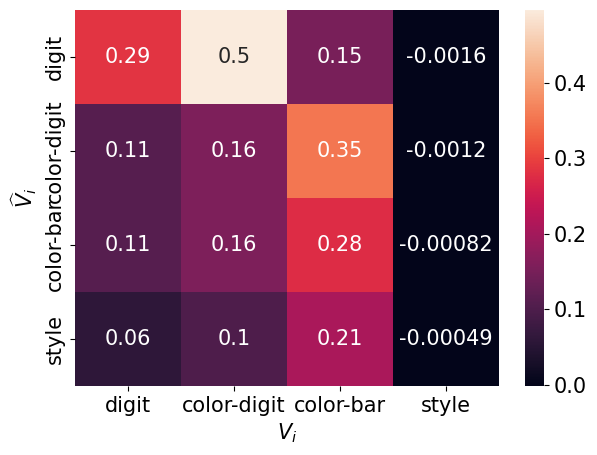

In [416]:
# min_corr = corr_arr.min()
# corr_arr = corr_arr - min_corr
# max_corr = corr_arr.max()
# corr_arr = corr_arr / max_corr

fig, ax = plt.subplots()
sns.heatmap(
    corr_arr.mean(axis=0),
    annot=True,
    xticklabels=latent_names,
    yticklabels=latent_names,
    ax=ax,
)
ax.set_ylabel("$\widehat{V}_i$")
ax.set_xlabel("$V_i$")

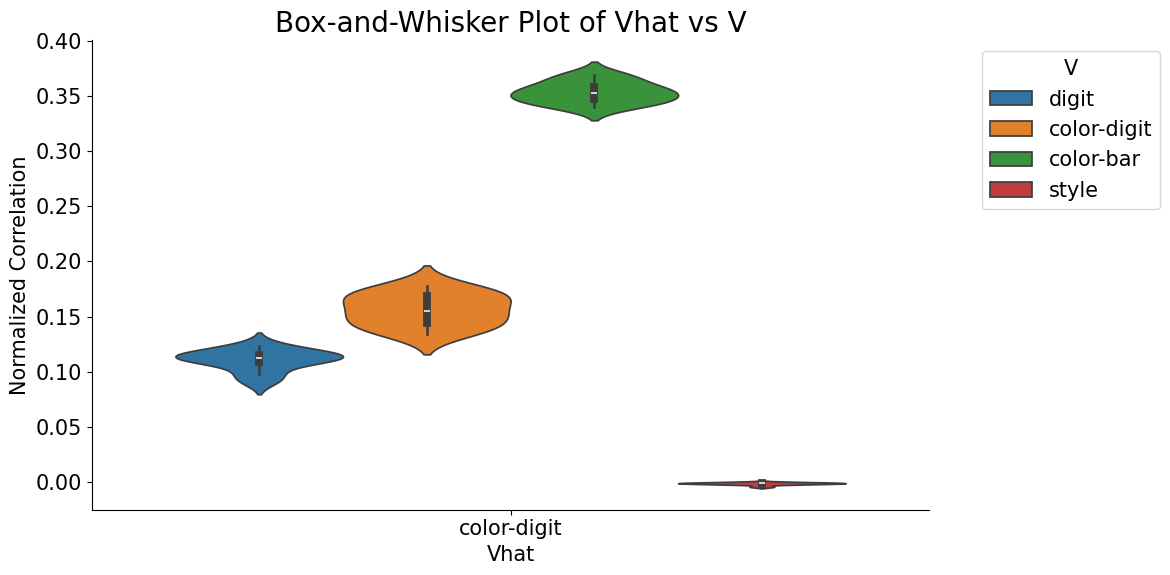

In [417]:
# Reshape corr_arr to long format
data = []
for rdx in range(n_repeats):
    for i, name_src in enumerate(latent_names):
        for j, name_target in enumerate(latent_names):
            data.append([rdx, name_src, name_target, corr_arr[rdx, i, j]])

# Create a DataFrame
df = pd.DataFrame(data, columns=["repeat", "Vhat", "V", "correlation"])
df = df[df["Vhat"] == "color-digit"]

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.violinplot(x="Vhat", y="correlation", hue="V", data=df)
plt.title("Box-and-Whisker Plot of Vhat vs V")
plt.xlabel("Vhat")
plt.ylabel("Normalized Correlation")
plt.legend(title="V", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

# Pick random images to compare their embeddings

In [251]:
import sys

sys.path.append("../")
sys.path.append("../vae_reduction/")
from config.config import load_config
from models import vae_models


def make_model(config):
    model_type = config.model_type
    model_config = config.model_configuration

    if model_type not in vae_models.keys():
        raise NotImplementedError("Model Architecture not implemented")
    else:
        return vae_models[model_type](**model_config.dict())


def load_vae_model(config, data_root, model_root):
    config.model_configuration.data_path = data_root
    model = make_model(config)
    checkpoint = torch.load(model_root, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint["state_dict"])
    return model


config = load_config("../config.yaml")

In [252]:
data_root = Path("/Users/adam2392/pytorch_data/full-causal-mnistv1/")
model_root = data_root / "vae-reduction" / "v1_conv-vae_alpha_1024_dim_32.ckpt"

# data_root = Path("/Users/adam2392/pytorch_data/full-causal-mnistv2/")
# model_root = data_root / "vae-reduction" / "v2_conv-vae_alpha_1024_dim_32.ckpt"

# load the VAE and extra the corresponding image
# load vae model
vae_model = load_vae_model(config, data_root, model_root)
vae_model.eval()

/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pydantic/main.py:364: UserWarning: Pydantic serializer warnings:
  Expected `str` but got `PosixPath` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Conv_VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [390]:
train_iter = iter(data_module.train_dataloader())

In [391]:
# randomly sample
batch = next(train_iter)
sample_imgs, sample_labels, sample_target = batch

print(sample_imgs.shape, sample_labels.shape, sample_target.shape)

torch.Size([160, 32]) torch.Size([160, 4]) torch.Size([160, 3])


In [377]:
print(sample_target)

tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 1]], dtype=torch.int32)


In [392]:
# Initialize an empty list to hold the sorted rows
sorted_rows = []
distribution_indices = sample_labels[:, -1]
# Loop through the unique distribution indices
for i in range(4):  # Assuming unique distribution indices are 0, 1, 2, and 3
    # Get the indices where the distribution index equals i
    indices = (distribution_indices == i).nonzero(as_tuple=True)[0]
    # Append the corresponding rows to the sorted_rows list
    sorted_rows.append(sample_imgs[indices])

# Concatenate the sorted rows into a single tensor
sorted_imgs = torch.cat(sorted_rows, dim=0)

with torch.no_grad():
    images = vae_model.decoder(sorted_imgs)
images = vae_model.scale_image(images)

print(images.shape)
# fig, ax = show_imgs(
#     images,
#     row_size=40,
#     ytick_labels=["Obs", "Int. Color-Bar", "Int. Color-Bar", "Int. Color Digit"],
#     figsize_scale=4.0
# )
# ax.set_yticklabels(["Obs", "Int. Color-Bar", "Int. Color-Bar", "Int. Width"])
# ax.set_yticks([(i + 0.5) * images.shape[1] / nrow for i in range(nrow)])
# ax.set_yticklabels()

torch.Size([160, 3, 28, 28])


# Intervene on Causal Prior to change the embeddings

In [402]:
# get observational images and their priors in the NF
obs_idx = np.argwhere(sample_labels[:, -1] == 0)[0]
obs_imgs = sample_imgs[obs_idx, ...]

# now forward these through the model
obs_embeddings = model.model.inverse(obs_imgs)

# intervene on the embedding in the relevant space
v_idx = latent_embeddings["color-bar"]
print(v_idx)
print(obs_embeddings.shape)
perturb_size = obs_embeddings[:, v_idx].shape
n_samples = obs_embeddings.shape[0]
# obs_embeddings[:, v_idx] += torch.ones(perturb_size) * 0.1
# print(np.random.permutation(n_samples))
new_arr = obs_embeddings[:, v_idx]
# permute_idx = np.random.permutation(n_samples)
# print(permute_idx)
# new_arr = new_arr[permute_idx]
# print(new_arr.shape)
# obs_embeddings[:, v_idx] = new_arr * -1.0
obs_embeddings[:, v_idx] += torch.Tensor(
    # np.random.randint(-1, 1, size=obs_embeddings[:, v_idx].shape) *
    0.6
    * np.random.normal(1.0, 1.00, size=obs_embeddings[:, v_idx].shape)
    # 0.75
    # * np.random.normal(-0.75, 0.25, size=obs_embeddings[:, v_idx].shape)
)
print(embeddings.shape)
print(obs_imgs.shape)

intervened_imgs = model.model.forward(obs_embeddings)
# fig, ax = show_imgs(
# images, ytick_labels=["Obs", "Int. Color-Bar", "Int. Color-Bar", "Int. Width"]

[18 19 20 21 22 23 24 25 26]
torch.Size([40, 32])
torch.Size([21600, 32])
torch.Size([40, 32])


In [403]:
print(intervened_imgs.shape)
with torch.no_grad():
    observed_imgs = vae_model.decoder(obs_imgs)
observed_imgs = vae_model.scale_image(observed_imgs)
with torch.no_grad():
    intervened_imgs = vae_model.decoder(intervened_imgs)
intervened_imgs = vae_model.scale_image(intervened_imgs)
print(intervened_imgs.shape)
print(obs_imgs.shape)

torch.Size([40, 32])
torch.Size([40, 3, 28, 28])
torch.Size([40, 32])


In [404]:
images = torch.vstack((observed_imgs, intervened_imgs))
save_image(
    observed_imgs,
    "/Users/adam2392/Downloads/06-obs-batch16-v1-disentanglecolorbar.pdf",
    nrow=4,
)
save_image(
    intervened_imgs,
    "/Users/adam2392/Downloads/06-int-batch16-v1-disentanglecolorbar.pdf",
    nrow=4,
)
print(images.shape)

torch.Size([80, 3, 28, 28])


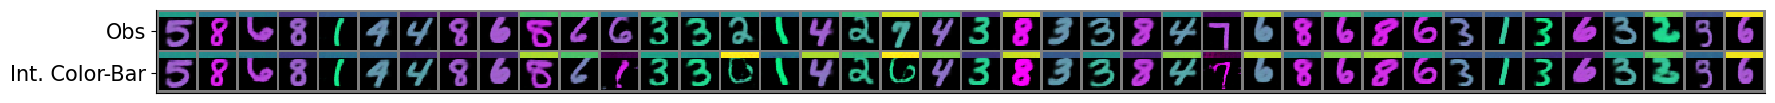

In [401]:
images = torch.vstack((observed_imgs, intervened_imgs))
fig, ax = show_imgs(
    images, row_size=40, ytick_labels=["Obs", "Int. Color-Bar"], figsize_scale=3.0
)
fig.savefig(
    "/Users/adam2392/Downloads/batch16-v1-disentanglecolorbar.pdf", bbox_inches="tight"
)

In [188]:
print(obs_embeddings[:, v_idx].detach().numpy())

[[-2.7220745  -1.9373041  -1.6980088  -4.4590836  -1.6825417  -1.3926399
  -2.9608727  -1.5782013  -2.0492282 ]
 [-3.167306   -2.109361   -1.4970746  -2.4686334  -2.9619687  -0.6925008
  -3.0035253  -1.2747737  -2.0203736 ]
 [-2.958283   -1.9826937  -1.4030273  -2.9947424  -1.535905   -1.1043533
  -2.4996316  -0.91895914 -2.6959033 ]
 [-3.6884556  -2.851555   -2.4255204  -1.2679508  -2.3818612  -3.3998618
  -2.8481667  -1.5534832  -2.8809555 ]]
